In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained('ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa')
model = AutoModelForSequenceClassification.from_pretrained('ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa')

In [3]:
# Function for tokenization and sentiment analysis
def analyze_sentiment(text, tokenizer, model, max_length=512):
    """
    Analyzes the sentiment of the given text using a pre-trained model.

    Args:
        text: The input text to analyze.
        tokenizer: The tokenizer object used to convert text to model input.
        model: The pre-trained sentiment analysis model.
        max_length: Maximum length of the input sequence. Defaults to 512.

    Returns:
        A tuple containing the predicted sentiment label and its confidence score.
    """
    # Tokenize the text, truncating if it exceeds the maximum length
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length, padding='max_length')
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    # Sentiment labels (adjust according to your model)
    labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    sentiment = labels[predicted_class]
    confidence = torch.softmax(logits, dim=1)[0][predicted_class].item()
    return sentiment, confidence

# Function for split text if too long
def split_text(text, tokenizer, max_length=512):
    """
    Splits the input text into smaller segments if it exceeds the maximum length.

    Args:
        text: The input text to be split.
        tokenizer: The tokenizer object used to convert text to token IDs.
        max_length: Maximum length of each segment. Defaults to 512 tokens.

    Returns:
        A list of text segments, where each segment has a maximum length of `max_length` tokens.
    """
    tokens = tokenizer(text, truncation=False)['input_ids']
    segments = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return [' '.join(tokenizer.convert_ids_to_tokens(segment)) for segment in segments]

In [4]:
# Load the kumparan data
df = pd.read_csv('kumparan_preprocessed_news_data.csv', sep='\t')

df.head()

,article_title,article_author,article_publication_date,article_content
0,"Respon Instruksi Presiden Jokowi, Kadiv Keimig...",Rutan Salatiga,10-10-2022,"SEMARANG - Menjadi Pembina Apel Pagi hari ini,..."
1,Kata Bobby soal Kabar Jokowi-Gibran Akan Masuk...,Salmah Muslimah,19-12-2024,"Presiden ke-7 RI Joko Widodo, dan Wapres RI, G..."
2,"Loyalis Jokowi Mulai Beralih ke Prabowo, Ganja...",JatimNow,27-02-2023,"jatimnow.com\nDi dalam surveinya, ia menemukan..."
3,Jokowi: Memang Masih Ditemukan Kasus Intoleran...,Wisnu Prasetiyo,29-08-2023,Presiden Jokowi berbicara soal toleransi di ac...
4,"Jokowi Cabut PPKM, Khofifah Minta Warga Jatim ...",JatimNow,30-12-2022,"jatimnow.com\nMenyikapi hal itu, Gubernur Jawa..."


In [5]:
# Sentiment analysis for each article

sentiments = []
confidences = []

print('Analysis in process')
for article_content in df['article_content']:
    article_sentiments = []
    article_confidences = []
    
    # Split the text into segments
    article_segments = split_text(article_content, tokenizer, max_length=512)

    # Sentiment analysis for each Segment
    for i, article_segment in enumerate(article_segments):
        article_sentiment, article_confidence = analyze_sentiment(article_segment, tokenizer, model)
        article_sentiments.append(article_sentiment)
        article_confidences.append(article_confidence)

    # Convert sentiment to a numeric value (positive=1, negative=-1, neutral=0)
    numerical_sentiment_scores = [1 if s == 'POSITIVE' else -1 if s == 'NEGATIVE' else 0 for s in article_sentiments]

    # Calculate the average of sentiment 
    average_sentiment_score = sum(numerical_sentiment_scores) / len(numerical_sentiment_scores)
    
    # Convert average score back to sentiment label
    if average_sentiment_score > 0:
        sentiment = 'POSITIVE'
    elif average_sentiment_score < 0:
        sentiment = 'NEGATIVE'
    else:
        sentiment = 'NEUTRAL'

    # Calculate the average of sentiment confident score
    confidence = sum(article_confidences) / len(article_confidences)

    sentiments.append(sentiment)
    confidences.append(confidence)

print('Analysis in done\n')

df['sentiment'] = sentiments
df['confidence'] = confidences

df.head()

Analysis in process
Analysis in done



,article_title,article_author,article_publication_date,article_content,sentiment,confidence
0,"Respon Instruksi Presiden Jokowi, Kadiv Keimig...",Rutan Salatiga,10-10-2022,"SEMARANG - Menjadi Pembina Apel Pagi hari ini,...",NEUTRAL,0.998133
1,Kata Bobby soal Kabar Jokowi-Gibran Akan Masuk...,Salmah Muslimah,19-12-2024,"Presiden ke-7 RI Joko Widodo, dan Wapres RI, G...",POSITIVE,0.917402
2,"Loyalis Jokowi Mulai Beralih ke Prabowo, Ganja...",JatimNow,27-02-2023,"jatimnow.com\nDi dalam surveinya, ia menemukan...",POSITIVE,0.774751
3,Jokowi: Memang Masih Ditemukan Kasus Intoleran...,Wisnu Prasetiyo,29-08-2023,Presiden Jokowi berbicara soal toleransi di ac...,NEGATIVE,0.996508
4,"Jokowi Cabut PPKM, Khofifah Minta Warga Jatim ...",JatimNow,30-12-2022,"jatimnow.com\nMenyikapi hal itu, Gubernur Jawa...",NEGATIVE,0.929789


In [6]:
# Save analysis result to csv

try:    
    df.to_csv('kumparan_analysis_result.csv', sep='\t', encoding='utf-8', index=False, header=True)
    print('Success saved article data to csv')
except Exception as e:
    print(f'Error occured while saved article data to csv: {e}')

Success saved article data to csv


In [7]:
# Load the kumparan analysis result

df = pd.read_csv('kumparan_analysis_result.csv', sep='\t')

df.head()

,article_title,article_author,article_publication_date,article_content,sentiment,confidence
0,"Respon Instruksi Presiden Jokowi, Kadiv Keimig...",Rutan Salatiga,10-10-2022,"SEMARANG - Menjadi Pembina Apel Pagi hari ini,...",NEUTRAL,0.998133
1,Kata Bobby soal Kabar Jokowi-Gibran Akan Masuk...,Salmah Muslimah,19-12-2024,"Presiden ke-7 RI Joko Widodo, dan Wapres RI, G...",POSITIVE,0.917402
2,"Loyalis Jokowi Mulai Beralih ke Prabowo, Ganja...",JatimNow,27-02-2023,"jatimnow.com\nDi dalam surveinya, ia menemukan...",POSITIVE,0.774751
3,Jokowi: Memang Masih Ditemukan Kasus Intoleran...,Wisnu Prasetiyo,29-08-2023,Presiden Jokowi berbicara soal toleransi di ac...,NEGATIVE,0.996508
4,"Jokowi Cabut PPKM, Khofifah Minta Warga Jatim ...",JatimNow,30-12-2022,"jatimnow.com\nMenyikapi hal itu, Gubernur Jawa...",NEGATIVE,0.929789


In [8]:
# Display the the number of rows x columns
df.shape

(491, 6)

In [9]:
# Summary statistics
df.describe()

,confidence
count,491.000000
mean,0.911786
std,0.139080
min,0.354195
25%,0.879094
50%,0.988737
75%,0.998716
max,0.999845


In [10]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   article_title             491 non-null    object 
 1   article_author            491 non-null    object 
 2   article_publication_date  491 non-null    object 
 3   article_content           491 non-null    object 
 4   sentiment                 491 non-null    object 
 5   confidence                491 non-null    float64
dtypes: float64(1), object(5)
memory usage: 23.1+ KB


In [11]:
# Check row where confidence score less than 0.6
len(df[df['confidence'] < 0.6])

31

In [12]:
# Drop row where confidence score less than 0.6
df = df[df['confidence'] >= 0.6]

len(df[df['confidence'] < 0.6])

0

In [13]:
# Display the the number of rows x columns after drop row where confidence score less than 0.6
df.shape

(460, 6)

In [14]:
# Display total number of negative, neutral, and positive sentiment
sentiment_each_type_count = {
    'NEGATIVE': len(df[df['sentiment'] == 'NEGATIVE']),
    'NEUTRAL': len(df[df['sentiment'] == 'NEUTRAL']),
    'POSITIVE': len(df[df['sentiment'] == 'POSITIVE']),
}

sentiment_each_type_count

{'NEGATIVE': 89, 'NEUTRAL': 207, 'POSITIVE': 164}

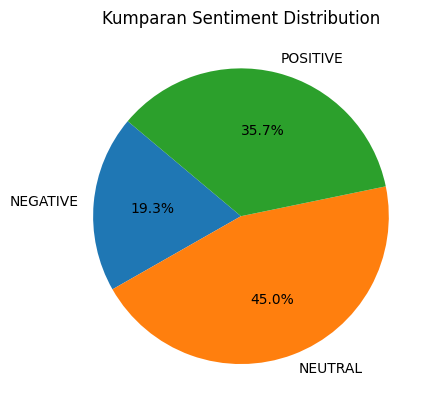

In [15]:
# Extract labels and values
labels = list(sentiment_each_type_count.keys())
values = list(sentiment_each_type_count.values())

# Create a pie chart 
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Kumparan Sentiment Distribution")

# Show the plot
plt.show()